In [14]:
# ==============================================================================
# CELL 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
import operator

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# Thư viện hỗ trợ
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True # Đặt là True để xem log chi tiết, False để chạy im lặng

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    """Hàm in một bước trong quy trình."""
    if VERBOSE_MODE:
        console.print(f"[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    """Hàm in kết quả (như JSON) một cách đẹp mắt."""
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)

# --- KHỞI TẠO LLM ---
try:
    llm = ChatGroq(
        temperature=0.1, model="llama3-70b-8192",
        api_key=os.getenv("GROQ_API_KEY"), max_tokens=2048
    )
    print("✅ LLM (Groq) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Lỗi: {e}")
    llm = None

✅ LLM (Groq) đã được khởi tạo thành công.


In [15]:
# ==============================================================================
# CELL 1.5: TẢI KHO TRI THỨC RAG ĐÃ XỬ LÝ SẴN
# ==============================================================================
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# --- CẤU HÌNH ---
VECTOR_STORE_PATH = "vector_store/sgk_toan_9"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"

# --- HÀM TẢI KHO TRI THỨC ---
def load_vector_store():
    """Tải kho tri thức đã được xây dựng từ local."""
    if not os.path.exists(VECTOR_STORE_PATH):
        print(f"❌ LỖI: Không tìm thấy kho tri thức tại '{VECTOR_STORE_PATH}'.")
        print("Vui lòng chạy file 'build_knowledge_base.py' trước để tạo kho tri thức.")
        return None
    
    try:
        print(f"✅ Đang tải kho tri thức từ: {VECTOR_STORE_PATH}...")
        embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
        db = FAISS.load_local(VECTOR_STORE_PATH, embeddings, allow_dangerous_deserialization=True)
        print("🎉 Tải kho tri thức thành công!")
        return db
    except Exception as e:
        print(f"❌ LỖI khi tải kho tri thức: {e}")
        return None

# --- TẢI VÀ SỬ DỤNG ---
vector_store = load_vector_store()

✅ Đang tải kho tri thức từ: vector_store/sgk_toan_9...
🎉 Tải kho tri thức thành công!


In [16]:
# ==============================================================================
# CELL 2: NÂNG CẤP STATE ĐỂ NHẬN BIẾT RÀNG BUỘC THỜI GIAN
# ==============================================================================
from langgraph.graph.message import add_messages

# --- Hàm tiện ích (Giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    # ... (code giữ nguyên)
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Định nghĩa các cấu trúc dữ liệu con ---
class AnalyzedObjective(TypedDict):
    action_verb: str
    bloom_level: int
    topic: str
    grade_level: str
    # === NÂNG CẤP ===
    # Thêm trường để lưu trữ các ràng buộc, bao gồm cả thời gian
    constraints: Dict[str, Any] 

class PedagogyStrategy(TypedDict):
    # ... (giữ nguyên)
    chosen_pedagogy: str
    pedagogy_rationale: str
    suggested_structure: List[Dict[str, Any]]

class Task(TypedDict):
    # ... (giữ nguyên)
    task_id: int
    task_name: str
    task_description: str
    status: Literal["pending", "completed"]

# --- Định nghĩa State chính (phiên bản hoàn chỉnh nhất) ---
class TeacherState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    analyzed_objective: Optional[AnalyzedObjective]
    pedagogy_strategy: Optional[PedagogyStrategy]
    task_list: Optional[List[Task]]
    current_task_id: Optional[int]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    final_lesson_plan: Optional[str]
    next_agent: str

print("✅ 'TeacherState' (phiên bản nâng cấp) đã được định nghĩa.")

✅ 'TeacherState' (phiên bản nâng cấp) đã được định nghĩa.


In [17]:
# ==============================================================================
# CELL 3: NÂNG CẤP CÁC AGENT VỚI LOGIC MỚI (PHIÊN BẢN 2.4 - SIÊU BỀN)
# ==============================================================================
import json
import re
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional

# --- ĐỊNH NGHĨA TẤT CẢ CÁC CẤU TRÚC PARSE Ở ĐÂY ---
class ParsedObjective(BaseModel):
    action_verb: str = Field(description="Động từ hành động chính, ví dụ: 'phân tích', 'trình bày'.")
    bloom_level: int = Field(description="Cấp độ tư duy theo thang Bloom (1-6).")
    topic: str = Field(description="Chủ đề chính của bài học.")
    grade_level: str = Field(description="Cấp lớp của học sinh, ví dụ: 'Lớp 9'.")
    duration_minutes: Optional[int] = Field(description="Tổng thời lượng cho phép của buổi học tính bằng phút (ví dụ: '2 tiết 45 phút' là 90). Nếu không có thì để null.")

class PedagogyChoice(BaseModel):
    chosen_pedagogy: str = Field(description="Tên phương pháp sư phạm được chọn.")
    pedagogy_rationale: str = Field(description="Lý do tại sao phương pháp này lại phù hợp.")

class TaskList(BaseModel):
    tasks: List[Dict[str, str]] = Field(description="Danh sách các nhiệm vụ, mỗi nhiệm vụ PHẢI có 'task_name' và 'task_description'.")

class TaskClassification(BaseModel):
    agent_category: Literal["activity_designer", "resource_scout", "assessment_creator", "unknown"] = Field(description="Loại agent nên thực hiện nhiệm vụ này.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Một cái tên hấp dẫn và rõ ràng cho hoạt động, ví dụ: 'Trạm kiến thức', 'Thí nghiệm vui'.")
    description: str = Field(description="Mô tả chi tiết các bước thực hiện hoạt động cho giáo viên và học sinh.")
    duration_minutes: int = Field(description="Thời gian dự kiến để hoàn thành hoạt động (tính bằng phút).")
    activity_type: str = Field(description="Loại hoạt động, ví dụ: 'Khởi động', 'Làm việc nhóm', 'Thực hành cá nhân', 'Thí nghiệm'.")

class AssessmentItem(BaseModel):
    question: str = Field(description="Nội dung câu hỏi hoặc yêu cầu của bài tập.")
    question_type: str = Field(description="Loại câu hỏi, ví dụ: 'Trắc nghiệm', 'Tự luận ngắn', 'Bài tập vận dụng'.")
    options: Optional[List[str]] = Field(description="Các lựa chọn trả lời nếu là câu hỏi trắc nghiệm.")
    answer: str = Field(description="Đáp án hoặc gợi ý đáp án cho câu hỏi.")

# --- CÁC HÀM TIỆN ÍCH ---
def update_agent_outputs(state: TeacherState, key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

# --- CÁC AGENTS ---

async def objective_interpreter_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v2.4) đang phân tích mục tiêu...")
    user_request = state['messages'][-1].content
    prompt = f"""Phân tích yêu cầu sau đây và trích xuất thông tin vào một đối tượng JSON.
    YÊU CẦU: "{user_request}"
    HƯỚNG DẪN:
    - `duration_minutes`: Quy đổi mọi thông tin về thời gian (ví dụ: '2 tiết 45 phút' ra 90) ra tổng số phút.
    QUAN TRỌNG: Chỉ trả về đối tượng JSON, không kèm theo bất kỳ văn bản giải thích nào.
    """
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    parsed_result = await structured_llm.ainvoke(prompt)
    analyzed_objective_dict = {
        "action_verb": parsed_result.action_verb, "bloom_level": parsed_result.bloom_level,
        "topic": parsed_result.topic, "grade_level": parsed_result.grade_level,
        "constraints": {"duration_minutes": parsed_result.duration_minutes}
    }
    print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
    return {"analyzed_objective": analyzed_objective_dict}

async def pedagogy_strategist_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("\n---\n### 🧑‍🏫 `Agent: Pedagogy Strategist` (v2.4) Bắt đầu...")
    objective = state['analyzed_objective']
    prompt = f"""Dựa vào mục tiêu sau, hãy chọn một chiến lược dạy học (Direct Instruction, Collaborative Learning, Inquiry-Based Learning, Hybrid Model) và giải thích lý do bằng Tiếng Việt.
    MỤC TIÊU: {objective}
    QUAN TRỌNG: Chỉ trả về đối tượng JSON theo class PedagogyChoice.
    """
    response = await llm.with_structured_output(schema=PedagogyChoice, method="json_mode").ainvoke(prompt)
    pedagogy_strategy_dict = response.dict()
    print_result(f"**Chiến lược:** {response.chosen_pedagogy}\n**Lý do:** {response.pedagogy_rationale}")
    return {"pedagogy_strategy": pedagogy_strategy_dict}
    
async def resource_scout_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("\n---\n### 📚 `Agent: Resource Scout (RAG)` (v2.4) Bắt đầu...")
    topic = state['analyzed_objective']['topic']
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    relevant_docs = retriever.invoke(topic)
    context = "\n\n---\n\n".join([doc.page_content for doc in relevant_docs])
    prompt = f"""Tóm tắt các kiến thức, định nghĩa, công thức cốt lõi về chủ đề '{topic}' từ các đoạn văn bản sau.
    VĂN BẢN: {context}
    """
    response = await llm.ainvoke(prompt)
    resource = {"source": "Sách giáo khoa Toán 9 (từ RAG)", "summary": response.content}
    print_result(resource, "Tài liệu RAG đã tìm thấy và tóm tắt")
    return update_agent_outputs(state, "resources", resource)

# === AGENT ĐƯỢC GIA CỐ ===
async def plan_delegator_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("\n---\n### 👷 `Agent: Plan Delegator` (v2.4) đang lập kế hoạch chiến lược...")
    objective = state['analyzed_objective']
    strategy = state['pedagogy_strategy']
    resources = state['agent_outputs'].get('resources', [])
    constraints = objective.get('constraints', {})

    prompt = f"""Bạn là một người lập kế hoạch giáo dục cực kỳ cẩn thận. Dựa vào các thông tin dưới đây, hãy tạo một danh sách nhiệm vụ.

    **Thông tin đầu vào:**
    1.  **Mục tiêu:** {objective['topic']} (Bloom: {objective['bloom_level']})
    2.  **Chiến lược:** {strategy['chosen_pedagogy']}
    3.  **Thời gian:** {constraints.get('duration_minutes', 'Không có')} phút
    4.  **Kiến thức có sẵn:** {json.dumps(resources, indent=2, ensure_ascii=False)}

    **YÊU CẦU ĐẦU RA (CỰC KỲ QUAN TRỌNG):**
    1.  Nhiệm vụ phải bám sát "Kiến thức có sẵn".
    2.  Tổng thời gian của các hoạt động được mô tả trong nhiệm vụ không được vượt quá giới hạn thời gian cho phép.
    3.  Luôn có một nhiệm vụ cuối cùng là "Tạo bài tập đánh giá".
    4.  **TUYỆT ĐỐI CHỈ** trả về một đối tượng JSON có key là "tasks".
    5.  **KHÔNG** thêm bất kỳ văn bản giải thích nào khác. Mỗi phần tử trong danh sách "tasks" PHẢI LÀ một dictionary có hai key là "task_name" và "task_description".
    """
    structured_llm = llm.with_structured_output(TaskList, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [
            {
                "task_id": i,
                "task_name": t.get('task_name', f"Nhiệm vụ không tên {i}"),
                "task_description": t.get('task_description', "Không có mô tả."),
                "status": "pending"
            }
            for i, t in enumerate(task_list_result.tasks) if t # Thêm điều kiện `if t` để bỏ qua các phần tử rỗng
        ]
        print_result(f"**Đã tạo {len(tasks_with_status)} nhiệm vụ chiến lược.**")
        return {"task_list": tasks_with_status}
    except Exception as e:
        print(f"❌ LỖI NGHIÊM TRỌNG tại Plan Delegator. Không thể parse kết quả từ LLM. Lỗi: {e}. Tạo một task mặc định để tiếp tục.")
        # Trả về một task mặc định để graph không bị sập hoàn toàn
        return {"task_list": [{"task_id": 0, "task_name": "Tạo hoạt động tổng quát", "task_description": "Do lỗi lập kế hoạch, hãy tạo một hoạt động tổng quát về hệ thức lượng.", "status": "pending"}]}

# ... (Các agent còn lại giữ nguyên) ...
async def activity_designer_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Activity Designer` (v2.4) đang thiết kế hoạt động sáng tạo...")
    objective = state['analyzed_objective']
    current_task_id = state.get("current_task_id")
    task_list = state.get("task_list", [])
    task_to_run = next((task for task in task_list if task.get("task_id") == current_task_id), None)
    
    resources_summary = json.dumps(state.get('agent_outputs', {}).get('resources', []), indent=2, ensure_ascii=False)
    previous_activities = json.dumps(state.get('agent_outputs', {}).get('activities', []), indent=2, ensure_ascii=False)

    if not task_to_run: return {}
        
    prompt = f"""Thiết kế một hoạt động dạy học SÁNG TẠO và KHÁC BIỆT.
    Bối cảnh: Dạy lớp {objective['grade_level']} về "{objective['topic']}".
    Kiến thức có sẵn: {resources_summary}
    Hoạt động đã tạo (để tránh lặp): {previous_activities}
    Nhiệm vụ cụ thể: "{task_to_run['task_description']}"
    QUAN TRỌNG: Chỉ trả về đối tượng JSON theo class LearningActivity.
    """
    structured_llm = llm.with_structured_output(LearningActivity, method="json_mode")
    activity_result = await structured_llm.ainvoke(prompt)
    print_result(activity_result.dict(), "Hoạt động sáng tạo đã được thiết kế")
    return update_agent_outputs(state, "activities", activity_result.dict())
    
async def assessment_creator_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Assessment Creator` (v2.4) đang tạo câu hỏi đánh giá...")
    objective = state['analyzed_objective']
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {}

    prompt = f"""Tạo MỘT câu hỏi đánh giá cho nhiệm vụ: "{task_to_run['task_description']}"
    QUAN TRỌNG: Chỉ trả về đối tượng JSON theo class AssessmentItem.
    """
    structured_llm = llm.with_structured_output(AssessmentItem, method="json_mode")
    assessment_result = await structured_llm.ainvoke(prompt)
    print_result(assessment_result.dict(), "Câu hỏi đánh giá đã được tạo")
    return update_agent_outputs(state, "assessments", assessment_result.dict())

async def lesson_plan_compiler_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Lesson Plan Compiler` (v2.4) đang tổng hợp giáo án...")
    outputs = state['agent_outputs']
    objective = state['analyzed_objective']
    activities = outputs.get('activities', [])
    total_duration = sum(act.get('duration_minutes', 0) for act in activities)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes')

    warning_message = f"Tổng thời lượng dự kiến: {total_duration} phút."
    if allowed_duration and total_duration > allowed_duration:
        warning_message += f" LƯU Ý: Vượt quá thời gian cho phép ({allowed_duration} phút). Cần điều chỉnh."
    
    prompt = f"""Tổng hợp các thông tin sau thành một giáo án Markdown hoàn chỉnh bằng Tiếng Việt.
    Mục tiêu: {objective['topic']}
    Hoạt động: {json.dumps(activities, indent=2, ensure_ascii=False)}
    Tài nguyên: {json.dumps(outputs.get('resources', []), indent=2, ensure_ascii=False)}
    Đánh giá: {json.dumps(outputs.get('assessments', []), indent=2, ensure_ascii=False)}
    YÊU CẦU: Cấu trúc rõ ràng và thêm "Ghi chú của Trợ lý AI" với nội dung: "{warning_message}"
    """
    response = await llm.ainvoke(prompt)
    return {"final_lesson_plan": response.content}

print("✅ Tất cả các agent đã được nâng cấp lên phiên bản 2.4 (Siêu bền).")

✅ Tất cả các agent đã được nâng cấp lên phiên bản 2.4 (Siêu bền).


✅ Graph 2.0 (Tích hợp RAG sớm & Trí nhớ) đã được biên dịch thành công.


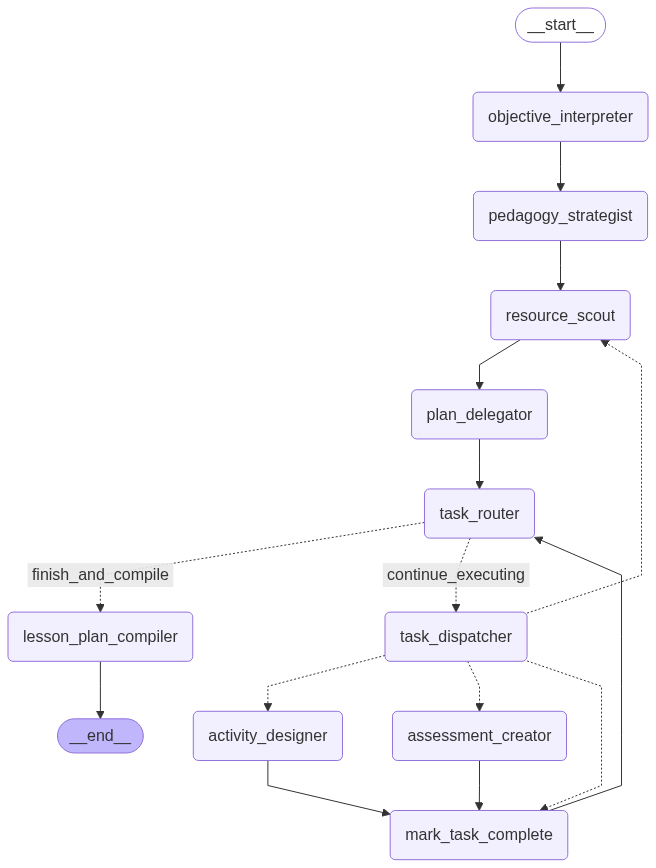

In [18]:
# ==============================================================================
# CELL 4: LẮP RÁP LẠI GRAPH VỚI LUỒNG LOGIC MỚI
# ==============================================================================

# --- Các hàm logic và node tiện ích (Giữ nguyên) ---
def mark_task_complete(state: TeacherState) -> Dict[str, Any]:
    # ... (code giữ nguyên)
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: TeacherState) -> Dict[str, Any]:
    # ... (code giữ nguyên)
    print_step("\n---\n### 🔄 `Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang tổng hợp giáo án.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: TeacherState) -> Dict[str, Any]:
    # ... (code giữ nguyên)
    print_step("\n---\n### 🚚 `Agent: Task Dispatcher` Bắt đầu...")
    current_task_id = state.get("current_task_id")
    task_list = state.get("task_list", [])
    task_to_run = next((task for task in task_list if task.get("task_id") == current_task_id), None)
    if not task_to_run: return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"""Phân loại nhiệm vụ sau vào agent phù hợp nhất: 'activity_designer', 'resource_scout', 'assessment_creator', hoặc 'unknown'.
    NHIỆM VỤ: "{task_description}" """
    structured_llm = llm.with_structured_output(TaskClassification)
    classification_result = await structured_llm.ainvoke(prompt)
    next_agent = classification_result.agent_category
    if next_agent == "unknown":
        print_step(f"--- 🚚 `Dispatcher`: Không nhận ra nhiệm vụ. Bỏ qua.")
        return {"next_agent": "mark_task_complete"}
    
    # *** Lưu ý: Chúng ta đã di chuyển Resource Scout ra khỏi vòng lặp này, 
    # nhưng vẫn giữ logic ở đây để phòng trường hợp Plan Delegator tạo ra một task tìm kiếm khác.
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def route_after_router(state: TeacherState) -> Literal["continue_executing", "finish_and_compile"]:
    # ... (code giữ nguyên)
    if state.get("current_task_id") is None:
        return "finish_and_compile"
    else:
        return "continue_executing"

# --- XÂY DỰNG GRAPH PHIÊN BẢN 2.0 ---
workflow = StateGraph(TeacherState)

# Thêm tất cả các node
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
# === THAY ĐỔI KIẾN TRÚC ===
# Resource Scout giờ sẽ chạy ngay sau khi có chiến lược sư phạm
workflow.add_node("resource_scout", resource_scout_agent) 
workflow.add_node("plan_delegator", plan_delegator_agent)
# ========================
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("lesson_plan_compiler", lesson_plan_compiler_agent)

# Kết nối các bước ban đầu theo "dây chuyền" mới
workflow.set_entry_point("objective_interpreter")
workflow.add_edge("objective_interpreter", "pedagogy_strategist")
# === THAY ĐỔI KIẾN TRÚC ===
workflow.add_edge("pedagogy_strategist", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
# ========================
workflow.add_edge("plan_delegator", "task_router")

# Vòng lặp xử lý nhiệm vụ (giữ nguyên logic)
workflow.add_conditional_edges(
    "task_router",
    route_after_router,
    {"continue_executing": "task_dispatcher", "finish_and_compile": "lesson_plan_compiler"}
)
workflow.add_conditional_edges(
    "task_dispatcher",
    lambda state: state["next_agent"],
    {
        "activity_designer": "activity_designer",
        "assessment_creator": "assessment_creator",
        # Resource Scout không còn là một điểm đến phổ biến trong vòng lặp này nữa
        "resource_scout": "resource_scout", 
        "mark_task_complete": "mark_task_complete"
    }
)
workflow.add_edge("activity_designer", "mark_task_complete")
workflow.add_edge("assessment_creator", "mark_task_complete")
workflow.add_edge("mark_task_complete", "task_router")

# Kết thúc
workflow.add_edge("lesson_plan_compiler", END)

# Biên dịch Graph 2.0
app = workflow.compile()
print("✅ Graph 2.0 (Tích hợp RAG sớm & Trí nhớ) đã được biên dịch thành công.")

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}")

In [19]:
# ==============================================================================
# CELL 5: CHẠY THỬ NGHIỆM VỚI KỊCH BẢN NÂNG CAO
# ==============================================================================

async def run_graph(user_request: str):
    # ... (code hàm run_graph giữ nguyên)
    initial_state = {
        "messages": [HumanMessage(content=user_request)],
        "agent_outputs": {},
        # ... các trường khác
    }
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH VỚI YÊU CẦU NÂNG CAO:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 50}
    final_state_result = None
    async for event in app.astream(initial_state, config=config):
        for node_name, node_output in event.items():
            console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
            final_state_result = node_output
    console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
    if final_state_result and final_state_result.get("final_lesson_plan"):
        console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v2)[/bold green]")
        console.print(Markdown(final_state_result["final_lesson_plan"]))


# --- KỊCH BẢN THỬ NGHIỆM MỚI ---
# Yêu cầu này có cả chủ đề RAG và RÀNG BUỘC THỜI GIAN
request_v2_test = "Soạn giúp tôi giáo án bài 'Hệ thức lượng trong tam giác vuông' cho học sinh lớp 9. Mục tiêu là các em có thể vận dụng được các tỉ số lượng giác sin, cos, tan để giải các bài toán thực tế. Buổi học sẽ diễn ra trong 2 tiết, tổng cộng 90 phút."

# --- BẬT/TẮT LOG CHI TIẾT ---
VERBOSE_MODE = True 

# --- CHẠY THỬ ---
# Chạy graph với yêu cầu đã được nâng cấp
await run_graph(request_v2_test) # Bỏ comment để chạy

🚀 BẮT ĐẦU QUY TRÌNH VỚI YÊU CẦU NÂNG CAO:
> Soạn giúp tôi giáo án bài 'Hệ thức lượng trong tam giác vuông' cho học sinh lớp 9. Mục tiêu là các em có thể vận 
dụng được các tỉ số lượng giác sin, cos, tan để giải các bài toán thực tế. Buổi học sẽ diễn ra trong 2 tiết, tổng 
cộng 90 phút.

> `Agent: Objective Interpreter` (v2.4) đang phân tích mục tiêu...

OutputParserException: Failed to parse ParsedObjective from completion {"lesson_plan": {"topic": "H\u1ec7 th\u1ee9c l\u01b0\u1ee3ng trong tam gi\u00e1c vu\u00f4ng", "grade_level": 9, "objectives": ["V\u1eadn d\u1ee5ng \u0111\u01b0\u1ee3c c\u00e1c t\u1ec9 s\u1ed1 l\u01b0\u1ee3ng gi\u00e1c sin, cos, tan \u0111\u1ec3 gi\u1ea3i c\u00e1c b\u00e0i to\u00e1n th\u1ef1c t\u1ebf"], "duration_minutes": 90}}. Got: 4 validation errors for ParsedObjective
action_verb
  field required (type=value_error.missing)
bloom_level
  field required (type=value_error.missing)
topic
  field required (type=value_error.missing)
grade_level
  field required (type=value_error.missing)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

In [ ]:
# ==============================================================================
# CELL 6: KIỂM TRA CHẤT LƯỢNG KHO TRI THỨC RAG
# ==============================================================================

def test_knowledge_base(query: str, top_k: int = 3):
    """
    Hàm để kiểm tra kho tri thức bằng một câu truy vấn.
    """
    if not vector_store:
        print("❌ Kho tri thức chưa được tải.")
        return

    console.print(f"\n[bold yellow]>>> Đang tìm kiếm với truy vấn:[/bold yellow] '{query}'")
    
    # Tạo một retriever để lấy ra k kết quả liên quan nhất
    retriever = vector_store.as_retriever(search_kwargs={"k": top_k})
    
    # Thực hiện tìm kiếm
    try:
        relevant_docs = retriever.invoke(query)
        
        if not relevant_docs:
            print("⚠️ Không tìm thấy tài liệu nào liên quan.")
            return

        console.print(f"[bold green]>>> Đã tìm thấy {len(relevant_docs)} đoạn văn bản liên quan:[/bold green]")
        
        for i, doc in enumerate(relevant_docs):
            # Lấy một đoạn preview ngắn của nội dung
            content_preview = doc.page_content.replace('\n', ' ').strip()[:300] + "..."
            
            # Lấy thông tin metadata (nếu có, ví dụ như số trang)
            page_number = doc.metadata.get('page', 'Không rõ')
            
            console.print(f"\n--- [ KẾT QUẢ #{i+1} | Trang: {page_number} ] ---")
            console.print(f"{content_preview}")

    except Exception as e:
        print(f"❌ Đã xảy ra lỗi khi tìm kiếm: {e}")

# --- THỰC HIỆN KIỂM TRA ---
if vector_store:
    # Kịch bản 1: Tìm một chủ đề cụ thể
    test_knowledge_base(query="Tỉ số lượng giác của góc nhọn")
    
    # Kịch bản 2: Tìm một định lý
    test_knowledge_base(query="Định lí Pytago")
    
    # Kịch bản 3: Tìm một dạng bài tập
    test_knowledge_base(query="Giải bài toán bằng cách lập hệ phương trình")
else:
    print("Vui lòng chạy lại Cell 1.5 để tải kho tri thức.")

>>> Đang tìm kiếm với truy vấn: 'Tỉ số lượng giác của góc nhọn'

>>> Đã tìm thấy 3 đoạn văn bản liên quan:

--- [ KẾT QUẢ #1 | Trang: Không rõ ] ---

Ta có thể xác định “góc dốc” $\alpha$ của một đoạn đường dốc khi biết tỉ số độ dài của dốc là l và độ cao của đỉnh 
dốc h so với đường nằm ngang là d, không? (H.4.1). Trong các toà chung cư, người ta thường thiết kế đoạn dốc cho 
người đi xe lăn với góc dốc bé hơn $6^\circ$.  =============== TRANG 67 ...

--- [ KẾT QUẢ #2 | Trang: Không rõ ] ---

**Nhận xét.** các bước giải một bài toán bằng cách lập hệ phương trình: **Bước 1.** Lập hệ phương trình: - Chọn ẩn 
số (thường chọn hai ẩn số) và đặt điều kiện thích hợp cho các ẩn số; - Biểu diễn các đại lượng chưa biết theo ẩn và
các đại lượng đã biết; - Lập hệ phương trình biểu thị mối quan hệ giữ...

--- [ KẾT QUẢ #3 | Trang: Không rõ ] ---

=============== TRANG 74 ===============  **Bài 12: MỘT SỐ HỆ THỨC GIỮA CẠNH, GÓC TRONG TAM GIÁC VUÔNG VÀ ỨNG 
DỤNG**  **Kiến thức, kĩ năng** *   Giải thích một số hệ thức về cạnh và góc trong tam giác vuông. *   Giải quyết 
một số vấn đề thực tiễn gắn với tỉ số lượng giác của góc nhọn.  Để đo chiều c...

>>> Đang tìm kiếm với truy vấn: 'Định lí Pytago'

>>> Đã tìm thấy 3 đoạn văn bản liên quan:

--- [ KẾT QUẢ #1 | Trang: Không rõ ] ---

**4.29.** Cho tam giác ABC vuông tại A, có $\hat{B} = \alpha$ (H.4.37). a) Hãy viết các tỉ số lượng giác $\sin 
\alpha, \cos \alpha$. b) Sử dụng định lí Pythagoras, chứng minh rằng $\sin^2 \alpha + \cos^2 \alpha = 1$.  
**4.30.** **ĐỐ VUI.** Chu vi Trái Đất bằng bao nhiêu? Vào khoảng năm 200 trước Côn...

--- [ KẾT QUẢ #2 | Trang: Không rõ ] ---

**4. RÚT GỌN BIỂU THỨC CHỨA CĂN THỨC BẬC HAI**  Khi rút gọn biểu thức chứa căn thức bậc hai, ta cần phối hợp các 
phép tính (cộng, trừ, nhân, chia) và các phép biến đổi đơn giản (đưa thừa số ra ngoài hoặc vào trong dấu căn; khử 
mẫu của biểu thức lấy căn; trục căn thức ở mẫu).  =============== TRANG 5...

--- [ KẾT QUẢ #3 | Trang: Không rõ ] ---

**3.16.** Trong Vật lí, tốc độ (m/s) của một vật đang bay được cho bởi công thức $v = \sqrt{\frac{2E}{m}}$, trong 
đó E là động năng của vật (tính bằng Joule, kí hiệu là J) và m (kg) là khối lượng của vật (Theo sách Vật lí đại 
cương, NXB Giáo dục Việt Nam, 2016). Tính tốc độ bay của một vật khi biết ...

>>> Đang tìm kiếm với truy vấn: 'Giải bài toán bằng cách lập hệ phương trình'

>>> Đã tìm thấy 3 đoạn văn bản liên quan:

--- [ KẾT QUẢ #1 | Trang: Không rõ ] ---

**Nhận xét.** các bước giải một bài toán bằng cách lập hệ phương trình: **Bước 1.** Lập hệ phương trình: - Chọn ẩn 
số (thường chọn hai ẩn số) và đặt điều kiện thích hợp cho các ẩn số; - Biểu diễn các đại lượng chưa biết theo ẩn và
các đại lượng đã biết; - Lập hệ phương trình biểu thị mối quan hệ giữ...

--- [ KẾT QUẢ #2 | Trang: Không rõ ] ---

**Chương II. PHƯƠNG TRÌNH VÀ BẤT PHƯƠNG TRÌNH BẬC NHẤT MỘT ẨN** Bài 4. Phương trình quy về phương trình bậc nhất 
một ẩn ... 26 Bài 5. Bất đẳng thức và tính chất ... 31 Luyện tập chung ... 36 Bài 6. Bất phương trình bậc nhất một 
ẩn ... 38 Bài tập cuối chương II ... 42  **Chương III. CĂN BẬC HAI VÀ CĂ...

--- [ KẾT QUẢ #3 | Trang: Không rõ ] ---

=============== TRANG 13 ===============  **2. PHƯƠNG PHÁP CỘNG ĐẠI SỐ**  **Làm quen với phương pháp cộng đại số** 
**HĐ2:** Cho hệ phương trình (II) $\begin{cases} 2x + 2y = 3 \\ x - 2y = 6 \end{cases}$. Ta thấy hệ số của y trong 
hai phương trình là hai số đối nhau (tổng của chúng bằng 0). Từ đặc đ...